# Synthetic Radiographs with Custom Source Profiles

[SyntheticProtronRadiography]: ../../api/plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.rst#plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph

In real charged particle radiography experiments, the finite size and distribution of the particle source limits the resolution of the radiograph. Some realistic sources produce particles with a non-uniform angular distribution that then superimposes a large scale "source profile" on the radiograph. For these reasons, the 
[SyntheticProtronRadiography] particle tracing class allows users to specify their own initial particle positions and velocities. This example will demonstrate how to use this functionality to create a more realistic synthetic radiograph that includes the effects from a non-uniform, finite source profile.

In [1]:
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from mpl_toolkits.mplot3d import Axes3D

from plasmapy.diagnostics import proton_radiography as prad
from plasmapy.formulary.mathematics import rot_a_to_b
from plasmapy.particles import Particle
from plasmapy.plasma.grids import CartesianGrid

## Contents

1. [Creating Particles](#Creating-Particles)
    1. [Creating the Initial Particle Velocities](#Creating-the-Initial-Particle-Velocities)
    1. [Creating the Initial Particle Positions](#Creating-the-Initial-Particle-Positions)
1. [Creating a Synthetic Radiograph](#Creating-a-Synthetic-Radiograph)

## Creating Particles

In this example we will create a source of 1e5 protons with a 5% variance in energy, a non-uniform angular velocity distribution, and a finite size.

In [2]:
nparticles = 1e5
particle = Particle("p+")

We will choose a setup in which the source-detector axis is parallel to the $y$-axis.

In [3]:
# define location of source and detector plane
source = (0 * u.mm, -10 * u.mm, 0 * u.mm)
detector = (0 * u.mm, 100 * u.mm, 0 * u.mm)

### Creating the Initial Particle Velocities

We will create the source distribution by utilizing the method of separation of variables,

$$f(v, \theta, \phi)=u(v)g(\theta)h(\phi)$$

and separately define the distribution component for each independent variable, $u(v)$, $g(\theta)$, and $h(\phi)$.  For geometric convenience, we will generate the velocity vector distribution around the $z$-axis and then rotate the final velocities to be parallel to the source-detector axis (in this case the $y$-axis).

<img src="proton_radiography_source_profile_setup_graphic.png">


First we will create the orientation angles polar ($\theta$) and azimuthal ($\phi$) for each particle. Generating $\phi$ is simple: we will choose the azimuthal angles to just be uniformly distributed

In [4]:
phi = np.random.uniform(high=2 * np.pi, size=int(nparticles))

However, choosing $\theta$ is more complicated. Since the solid angle $d\Omega = sin \theta d\theta d\phi$, if we draw a uniform distribution of $\theta$ we will create a non-uniform distribution of particles in solid angle. This will create a sharp central peak on the detector plane.

(0.0009225017887949872, 1)

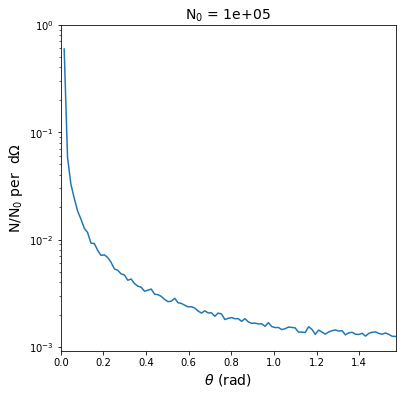

In [5]:
theta = np.random.uniform(high=np.pi / 2, size=int(nparticles))

fig, ax = plt.subplots(figsize=(6, 6))
theta_per_sa, bins = np.histogram(theta, bins=100, weights=1 / np.sin(theta))
ax.set_xlabel("$\\theta$ (rad)", fontsize=14)
ax.set_ylabel("N/N$_0$ per  d$\\Omega$", fontsize=14)
ax.plot(bins[1:], theta_per_sa / np.sum(theta_per_sa))
ax.set_title(f"N$_0$ = {nparticles:.0e}", fontsize=14)
ax.set_yscale("log")
ax.set_xlim(0, np.pi / 2)
ax.set_ylim(None, 1)

[np.random.choice()]: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

To create a uniform distribution in solid angle, we need to draw values of $\theta$ with a probability distribution weighted by $\sin \theta$. This can be done using the [np.random.choice()] function, which draws `size` elements from a distribution `arg` with a probability distribution `prob`. Setting the `replace` keyword allows the same arguments to be drawn multiple times.

(0.006375858878247144, 0.1)

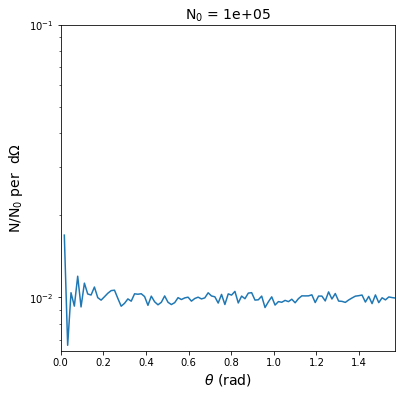

In [6]:
arg = np.linspace(0, np.pi / 2, num=int(1e5))
prob = np.sin(arg)
prob *= 1 / np.sum(prob)
theta = np.random.choice(arg, size=int(nparticles), replace=True, p=prob)

fig, ax = plt.subplots(figsize=(6, 6))
theta_per_sa, bins = np.histogram(theta, bins=100, weights=1 / np.sin(theta))
ax.plot(bins[1:], theta_per_sa / np.sum(theta_per_sa))
ax.set_xlabel("$\\theta$ (rad)", fontsize=14)
ax.set_ylabel("N/N$_0$ per  d$\\Omega$", fontsize=14)
ax.set_title(f"N$_0$ = {nparticles:.0e}", fontsize=14)
ax.set_yscale("log")
ax.set_xlim(0, np.pi / 2)
ax.set_ylim(None, 0.1)

[np.random.choice()]: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
[create_particles()]: ../../api/plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.rst#plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.create_particles

Now that we have a $\theta$ distribution that is uniform in solid angle, we can perturb it by adding additional factors to the probability distribution used in [np.random.choice()]. For this case, let's create a Gaussian distribution in solid angle.

Since particles moving at large angles will not be seen in the synthetic radiograph, we will set an upper bound $\theta_{max}$ on the argument here. This is equivalent to setting the `max_theta` keyword in [create_particles()]

(1.0588395775587949e-06, 1)

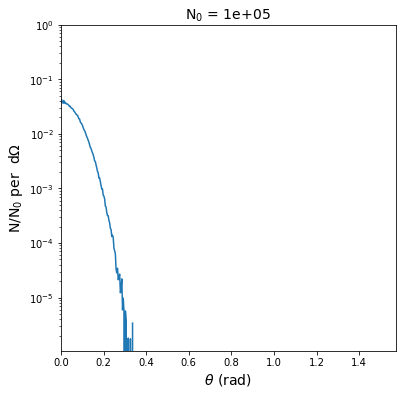

In [7]:
arg = np.linspace(0, np.pi / 8, num=int(1e5))
prob = np.sin(arg) * np.exp(-(arg ** 2) / 0.1 ** 2)
prob *= 1 / np.sum(prob)
theta = np.random.choice(arg, size=int(nparticles), replace=True, p=prob)

fig, ax = plt.subplots(figsize=(6, 6))
theta_per_sa, bins = np.histogram(theta, bins=100, weights=1 / np.sin(theta))
ax.plot(bins[1:], theta_per_sa / np.sum(theta_per_sa))
ax.set_title(f"N$_0$ = {nparticles:.0e}", fontsize=14)
ax.set_xlabel("$\\theta$ (rad)", fontsize=14)
ax.set_ylabel("N/N$_0$ per  d$\\Omega$", fontsize=14)
ax.set_yscale("log")
ax.set_xlim(0, np.pi / 2)
ax.set_ylim(None, 1)

Now that the angular distributions are done, we will determine the energy (speed) for each particle. For this example, we will assume that the particle energy distribution is not a function of angle. We will create a Gaussian distribution of speeds with ~5% variance centered on a particle energy of 15 MeV.

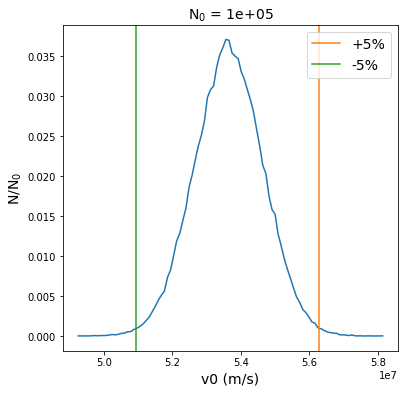

In [8]:
v_cent = np.sqrt(2 * 15 * u.MeV / particle.mass).to(u.m / u.s).value
v0 = np.random.normal(loc=v_cent, scale=1e6, size=int(nparticles))
v0 *= u.m / u.s

fig, ax = plt.subplots(figsize=(6, 6))
v_per_bin, bins = np.histogram(v0.si.value, bins=100)
ax.plot(bins[1:], v_per_bin / np.sum(v_per_bin))
ax.set_title(f"N$_0$ = {nparticles:.0e}", fontsize=14)
ax.set_xlabel("v0 (m/s)", fontsize=14)
ax.set_ylabel("N/N$_0$", fontsize=14)
ax.axvline(x=1.05 * v_cent, label="+5%", color="C1")
ax.axvline(x=0.95 * v_cent, label="-5%", color="C2")
ax.legend(fontsize=14, loc="upper right")

Next, we will construct velocity vectors centered around the z-axis for each particle.

In [9]:
vel = np.zeros([int(nparticles), 3]) * u.m / u.s
vel[:, 0] = v0 * np.sin(theta) * np.cos(phi)
vel[:, 1] = v0 * np.sin(theta) * np.sin(phi)
vel[:, 2] = v0 * np.cos(theta)

[rot_a_to_b()]: ../../api/plasmapy.formulary.mathematics.rot_a_to_b.rst#plasmapy.formulary.mathematics.rot_a_to_b

Finally, we will use the function [rot_a_to_b()] to create a rotation matrix that will rotate the `vel` distribution so the distribution is centered about the $y$ axis instead of the $z$ axis.

In [10]:
a = np.array([0, 0, 1])
b = np.array([0, 1, 0])
R = rot_a_to_b(a, b)
vel = np.matmul(vel, R)

Since the velocity vector distribution should be symmetric about the $y$ axis, we can confirm this by checking that the normalized average velocity vector is close to the $y$ unit vector.

In [11]:
avg_v = np.mean(vel, axis=0)
print(avg_v / np.linalg.norm(avg_v))

[-3.84095527e-04  9.99999920e-01 -1.10859180e-04]


### Creating the Initial Particle Positions

For this example, we will create an initial position distribution representing a laser spot centered on the source location defined above as `source`. The distribution will be cylindrical (oriented along the $y$-axis) with a uniform distribution in y and a Gaussian distribution in radius (in the xz plane). We therefore need to create distributions in $y$, $\theta$, and $r$, and then transform those into Cartesian positions.

Just as we previously weighted the $\theta$ distribution with a $sin \theta$ probability distribution to generate a uniform distribution in solid angle, we need to weight the $r$ distribution with a $r$ probability distribution so that the particles are uniformly distributed over the area of the disk.

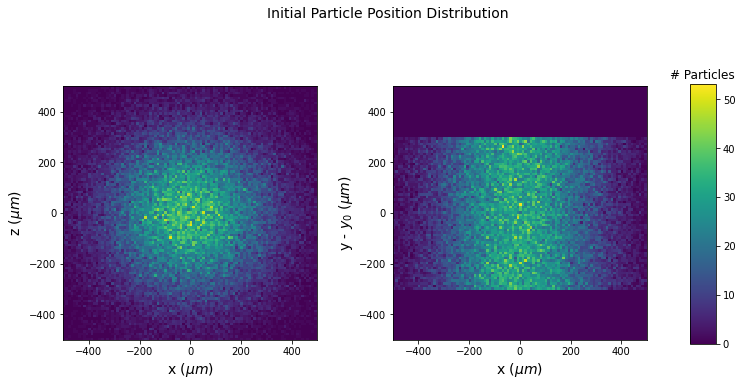

In [12]:
dy = 300 * u.um
y = np.random.uniform(
    low=(source[1] - dy).to(u.m).value,
    high=(source[1] + dy).to(u.m).value,
    size=int(nparticles),
)

arg = np.linspace(1e-9, 1e-3, num=int(1e5))
prob = arg * np.exp(-((arg / 3e-4) ** 2))
prob *= 1 / np.sum(prob)
r = np.random.choice(arg, size=int(nparticles), replace=True, p=prob)


theta = np.random.uniform(low=0, high=2 * np.pi, size=int(nparticles))

x = r * np.cos(theta)
z = r * np.sin(theta)

hist, xpos, zpos = np.histogram2d(
    x * 1e6, z * 1e6, bins=[100, 100], range=np.array([[-5e2, 5e2], [-5e2, 5e2]])
)

hist2, xpos2, ypos = np.histogram2d(
    x * 1e6,
    (y - source[1].to(u.m).value) * 1e6,
    bins=[100, 100],
    range=np.array([[-5e2, 5e2], [-5e2, 5e2]]),
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3, right=0.8)
fig.suptitle("Initial Particle Position Distribution", fontsize=14)
vmax = np.max([np.max(hist), np.max(hist2)])

p1 = ax[0].pcolormesh(xpos, zpos, hist.T, vmax=vmax)
ax[0].set_xlabel("x ($\\mu m$)", fontsize=14)
ax[0].set_ylabel("z ($\\mu m$)", fontsize=14)
ax[0].set_aspect("equal")

p2 = ax[1].pcolormesh(xpos2, ypos, hist2.T, vmax=vmax)
ax[1].set_xlabel("x ($\\mu m$)", fontsize=14)
ax[1].set_ylabel("y - $y_0$ ($\\mu m$)", fontsize=14)
ax[1].set_aspect("equal")

cbar_ax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
cbar_ax.set_title("# Particles")
fig.colorbar(p2, cax=cbar_ax)

Finally we will combine these position arrays into an array with units.

In [13]:
pos = np.zeros([int(nparticles), 3]) * u.m
pos[:, 0] = x * u.m
pos[:, 1] = y * u.m
pos[:, 2] = z * u.m

## Creating a Synthetic Radiograph

To create an example synthetic radiograph, we will first create a field grid representing the analytical electric field produced by a sphere of Gaussian potential.

Text(0.5, 0.92, 'Gaussian Potential Electric Field')

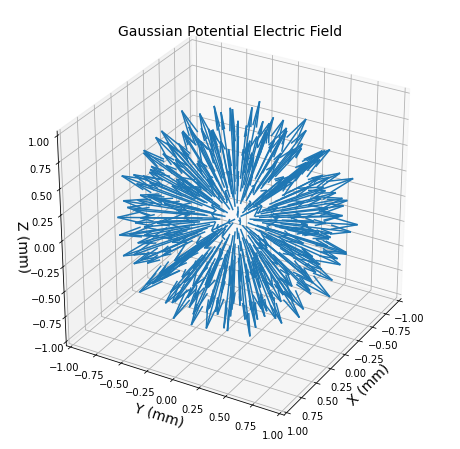

In [14]:
# Create a Cartesian grid
L = 1 * u.mm
grid = CartesianGrid(-L, L, num=100)

# Create a spherical potential with a Gaussian radial distribution
radius = np.linalg.norm(grid.grid, axis=3)
arg = (radius / (L / 3)).to(u.dimensionless_unscaled)
potential = 6e5 * np.exp(-(arg ** 2)) * u.V

# Calculate E from the potential
Ex, Ey, Ez = np.gradient(potential, grid.dax0, grid.dax1, grid.dax2)
mask = radius < L / 2
Ex = -np.where(mask, Ex, 0)
Ey = -np.where(mask, Ey, 0)
Ez = -np.where(mask, Ez, 0)

# Add those quantities to the grid
grid.add_quantities(E_x=Ex, E_y=Ey, E_z=Ez, phi=potential)


# Plot the E-field
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)

# skip some points to make the vector plot intelligable
s = tuple([slice(None, None, 6)] * 3)

ax.quiver(
    grid.pts0[s].to(u.mm).value,
    grid.pts1[s].to(u.mm).value,
    grid.pts2[s].to(u.mm).value,
    grid["E_x"][s],
    grid["E_y"][s],
    grid["E_z"][s],
    length=5e-7,
)

ax.set_xlabel("X (mm)", fontsize=14)
ax.set_ylabel("Y (mm)", fontsize=14)
ax.set_zlabel("Z (mm)", fontsize=14)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_title("Gaussian Potential Electric Field", fontsize=14)

We will then create the synthetic radiograph object. The warning filter ignores a warning that arises because $B_x$, $B_y$, $B_z$ are not provided in the grid (they will be assumed to be zero).

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sim = prad.SyntheticProtonRadiograph(grid, source, detector, verbose=False)

[create_particles()]: ../../api/plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.rst#plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.create_particles

[load_particles()]: ../../api/plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.rst#plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.load_particles

Now, instead of using [create_particles()] to create the particle distribution, we will use the [load_particles()] function to use the particles we have created above.

In [16]:
sim.load_particles(pos, vel, particle=particle)

Now the particle radiograph simulation can be run as usual.

In [17]:
sim.run()

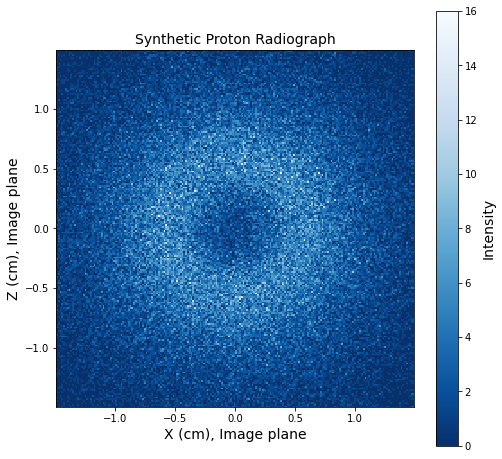

In [18]:
size = np.array([[-1, 1], [-1, 1]]) * 1.5 * u.cm
bins = [200, 200]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)

fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(
    hax.to(u.cm).value, vax.to(u.cm).value, intensity.T, cmap="Blues_r", shading="auto",
)
cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity", fontsize=14)
ax.set_aspect("equal")
ax.set_xlabel("X (cm), Image plane", fontsize=14)
ax.set_ylabel("Z (cm), Image plane", fontsize=14)
ax.set_title("Synthetic Proton Radiograph", fontsize=14);

[synthetic_radiograph()]: ../../api/plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.rst#plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph.synthetic_radiograph

Calling the [synthetic_radiograph()] function with the `ignore_grid` keyword will produce the synthetic radiograph corresponding to the source profile propagated freely through space (i.e. in the absence of any grid fields).

Text(0.5, 1.0, 'Source Profile')

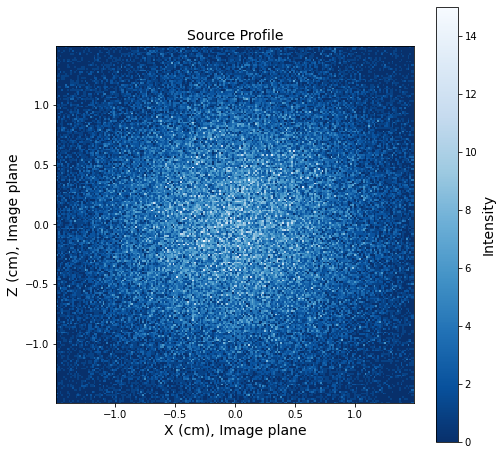

In [19]:
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins, ignore_grid=True)

fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(
    hax.to(u.cm).value, vax.to(u.cm).value, intensity.T, cmap="Blues_r", shading="auto",
)
cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity", fontsize=14)
ax.set_aspect("equal")
ax.set_xlabel("X (cm), Image plane", fontsize=14)
ax.set_ylabel("Z (cm), Image plane", fontsize=14)
ax.set_title("Source Profile", fontsize=14)

Text(0.5, 1.0, 'Mean source profile')

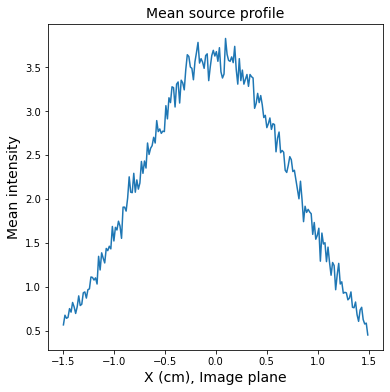

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(hax.to(u.cm).value, np.mean(intensity, axis=0))
ax.set_xlabel("X (cm), Image plane", fontsize=14)
ax.set_ylabel("Mean intensity", fontsize=14)
ax.set_title("Mean source profile", fontsize=14)